# CAICT 風機結冰預測 - Model _ Predict Power

2017/07/23  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

In [44]:
from IPython.display import HTML
HTML('''<script>
presentation = 1;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


### Summary

### Outline
- [1. Load Data and Modules](#load)  
- [2. Select Features](feature)
- [3. Check Auto Correlation](#autocorrelation)
- [4. Modeling](#modeling)



<a id='load'></a>
## 1. Load Data and Modules

In [45]:
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import matplotlib.pyplot as plt
import shutil
import csv
import sklearn as sk
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import precision_score
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from collections import OrderedDict

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn import tree
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFE
from sklearn import svm
import xgboost as xgb
from mlxtend.classifier import StackingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [46]:
def normalize(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def load_resample_data(id, policy=1, ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    #data_resample['label']=data_resample['label'].fillna(2)
    #data_resample = data_resample[data_resample['label']!=2]
    #data_resample=data_resample.dropna()
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_X = data_X.drop([ycol], axis=1)
    
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_resample_data_passonly(id, policy=1, ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    data_resample = data_resample[data_resample['label']==0]
    data_resample=data_resample.dropna()
    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_X = data_X.drop([ycol], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y

def load_resample_data_split(id, split_case, policy=1, ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=id,POLICY=policy)
    data_resample = pd.read_csv(filename)
    #data_resample['label']=data_resample['label'].fillna(2)
    #data_resample = data_resample[data_resample['label']!=2]
    #data_resample=data_resample.dropna()
    data_resample_train = data_resample[data_resample['event']<split_case]
    data_resample_valid = data_resample[data_resample['event']>=split_case]
    train_X = data_resample_train.drop(['label','time','group','timestamp','event'], axis=1)
    train_X = train_X.drop([ycol], axis=1)
    train_y = data_resample_train[ycol]
    valid_X = data_resample_valid.drop(['label','time','group','timestamp','event'], axis=1)
    valid_X = valid_X.drop([ycol], axis=1)
    valid_y = data_resample_valid[ycol]
    train_Y = np.eye(train_y.unique().size)[train_y.values.astype(int)]
    valid_Y = np.eye(valid_y.unique().size)[valid_y.values.astype(int)]
    return data_resample, train_X, train_Y, train_y, valid_X, valid_Y, valid_y


def load_test2_data(varsel=False):
    test_data = pd.read_csv('data/ice1/test/08/08_data.csv')
    if varsel:
        test_data=variable_selection(test_data,isTest=True)
    test_timeidx = test_data['time']
    tmp = test_data.drop(['time','group'], axis=1)
    test_X = tmp
    return test_data, test_X, test_timeidx


In [47]:
def trend_chart(data, event_id, varlist, ma=50):
    if type(event_id) is int:
        event_id=[event_id]
    print('event:',event_id)
    for eid in event_id:
        evtdata = data[data['event']==eid]
        evtdata_nor=evtdata[evtdata['label']==0]
        evtdata_abnor=evtdata[evtdata['label']==1]
        evtdata_unknown=evtdata[evtdata['label']==2]

        for var in varlist:
            dummy = plt.figure(figsize=[17,2])
            dummy = plt.plot(evtdata_nor[var], color='green',marker='o',ms=1,label='pass')
            dummy = plt.plot(evtdata_unknown[var], color='gray',marker='o',ms=1, label='unknown')
            dummy = plt.plot(evtdata_abnor[var], color='red',marker='o',ms=1, label='fail')
            plt.title('event '+str(eid)+'\t'+var,fontsize='large')
            
            dummy = plt.plot(pd.rolling_mean(evtdata[var],ma), color='blue',lw=0.8, label='orig_ma')
            #dummy = plt.plot(evtdata['timestamp'],pd.rolling_std(evtdata[var],ma), color='yellow',lw=0.8)
            #dummy = plt.plot(evtdata['timestamp'],evtdata['pred'], color='cyan',lw=0.8, label='pred')
            dummy = plt.plot(pd.rolling_mean(evtdata['pred'],ma), color='yellow',lw=0.8, label='pred_ma')
            pred_diff =  pd.rolling_mean(evtdata[var],ma) - pd.rolling_mean(evtdata['pred'],ma)
            dummy = plt.plot(np.abs(pred_diff), color='black',lw=0.9, label='pred_diff')
            
            plt.legend()
        dummy = plt.show()

In [48]:
def myscore_mse(true_y, pred_y):
    loss = sk.metrics.mean_squared_error(true_y, pred_y)
    msg = 'mse:{l}'.format(l=loss)
    return loss, msg    

def mycv_mse(model_log, train_X, train_y):
    kf = model_selection.KFold(10)
    loss_list=[]
    for train,test in kf.split(train_X):
        model_log = model_log.fit(train_X.values[train],train_y.values[train])
        pred_y = model_log.predict(train_X.values[test])       
        loss, _ = myscore_mse(train_y.values[test], pred_y)
        loss_list.append(loss)
    msg = 'loss:{l}'.format(l=np.mean(loss_list))
    return np.mean(loss_list), msg

***

In [49]:
print('data resample policy:')
filename = 'data/resample_policy_desc.csv'
policy_desc = pd.read_csv(filename)
policy_desc

data resample policy:


,policy_desc
0,no resample
1,event data + normal data (before and after eve...
2,half event data + normal data (before event on...
3,event data + normal data (before event only)


**Load input data.** 

In [50]:
train_p_raw, train_p_X, train_p_Y, train_p_y = load_resample_data_passonly(id=15, policy=0, ycol='power')

valid_15_raw, valid_15_X, valid_15_Y, valid_15_y = load_resample_data(id=15, policy=3, ycol='power')
valid_21_raw, valid_21_X, valid_21_Y, valid_21_y = load_resample_data(id=21, policy=3, ycol='power')

valid_15_A_raw, valid_15_A_X, valid_15_A_Y, valid_15_A_y = load_resample_data(id=15, policy=0, ycol='power')
valid_21_A_raw, valid_21_A_X, valid_21_A_Y, valid_21_A_y = load_resample_data(id=21, policy=0, ycol='power')
test_raw, test_X,test_timeidx = load_test2_data(varsel=False)

** Normalize **

In [51]:
train_p_X = normalize(train_p_X)
valid_15_X = normalize(valid_15_X)
valid_21_X = normalize(valid_21_X)

valid_15_A_X = normalize(valid_15_A_X)
valid_21_A_X = normalize(valid_21_A_X)

test_X = normalize(test_X)

**風機15 Training/Validation Data 狀態正常(0)/異常(1)比例 **

<a id='feature'></a>
## 2. Select Features

目前，特徵選擇最流行方法是遞歸特徵選擇（Recursive Feature Selection，RFE）。  
RFE 可以創建預測模型，對特徵值賦予不同的權值，並刪掉那些權重最小的特徵，通過不斷重複這一流程，最終就能得到預期數量的特徵

In [52]:
print('Feature Ranking:')
rfe = RFE(Ridge(), 1)
fit = rfe.fit(train_p_X,train_p_y)
feature_imp = pd.DataFrame(list(zip(train_p_X.columns, np.transpose(fit.ranking_))), columns=['feature','ranking'])
feature_imp = feature_imp.sort_values(by='ranking', ascending=True).reset_index(drop=True)
feature_imp

Feature Ranking:


,feature,ranking
0,pitch1_moto_tmp,1
1,pitch2_moto_tmp,2
2,pitch3_moto_tmp,3
3,generator_speed,4
4,wind_speed,5
5,pitch2_angle,6
6,pitch3_angle,7
7,int_tmp,8
8,environment_tmp,9
9,pitch1_angle,10


In [53]:
selected_vars = train_p_X.columns#['wind_speed',  'environment_tmp','int_tmp','acc_x', 'wind_direction_mean', 'pitch1_moto_tmp', 'pitch1_angle']
train_p_X = train_p_X[selected_vars]
valid_15_X = valid_15_X[selected_vars]
valid_21_X = valid_21_X[selected_vars]
valid_15_A_X = valid_15_A_X[selected_vars]
valid_21_A_X = valid_21_A_X[selected_vars]
test_X = test_X[selected_vars]
print('selected vars',train_p_X.columns)

selected vars Index(['wind_speed', 'generator_speed', 'wind_direction',
       'wind_direction_mean', 'yaw_position', 'yaw_speed', 'pitch1_angle',
       'pitch2_angle', 'pitch3_angle', 'pitch1_speed', 'pitch2_speed',
       'pitch3_speed', 'pitch1_moto_tmp', 'pitch2_moto_tmp', 'pitch3_moto_tmp',
       'acc_x', 'acc_y', 'environment_tmp', 'int_tmp', 'pitch1_ng5_tmp',
       'pitch2_ng5_tmp', 'pitch3_ng5_tmp', 'pitch1_ng5_DC', 'pitch2_ng5_DC',
       'pitch3_ng5_DC'],
      dtype='object')


<a id='modeling'></a>
### 3. Modeling

** 1. Linear Regression **

In [ ]:
#LinearRegression,Lasso,Ridge
model_lreg = LinearRegression()
loss_log, msg = mycv_mse(model_lreg, train_p_X,train_p_y)
print('train(15):',msg)

model_lreg = model_lreg.fit(train_p_X.values,train_p_y.values)

pred_y = model_lreg.predict(valid_15_A_X.values)
loss_log_15, msg=myscore_mse(valid_15_A_y, pred_y)
print('\nvalid(15):',msg)

pred_y = model_lreg.predict(valid_21_A_X.values)
loss_log_21, msg=myscore_mse(valid_21_A_y, pred_y)
print('\nvalid(21):',msg)

train(15): loss:0.05272539647730935

valid(15): mse:0.05211934558181546

valid(21): mse:0.40360533463841913


**2. Random Forest **

In [ ]:
model_rf = RandomForestRegressor(
    n_estimators=100, \
    max_depth=None, \
    min_samples_split=50 \
    #class_weight="balanced", \
    #min_weight_fraction_leaf=0.02 \
    )

loss_rf, msg = mycv_mse(model_rf, train_p_X,train_p_y)
print('train(15):',msg)

model_rf = model_rf.fit(train_p_X.values,train_p_y.values)

pred_y = model_rf.predict(valid_15_A_X.values)
loss_log_15, msg=myscore_mse(valid_15_A_y, pred_y)
print('\nvalid(15):',msg)

pred_y = model_rf.predict(valid_21_A_X.values)
loss_rf_21, msg=myscore_mse(valid_21_A_y, pred_y)
print('\nvalid(21):',msg)

** eXtreme Gradient Boosting (XGBoost) **

In [ ]:
model_xgb = xgb.XGBRegressor()


loss_xgb, msg = mycv_mse(model_xgb, train_p_X,train_p_y)
print('train(15):',msg)

model_xgb = model_xgb.fit(train_p_X.values,train_p_y.values)

pred_y = model_xgb.predict(valid_15_A_X.values)
loss_log_15, msg=myscore_mse(valid_15_A_y, pred_y)
print('\nvalid(15):',msg)

pred_y = model_xgb.predict(valid_21_A_X.values)
loss_xgb_21, msg=myscore_mse(valid_21_A_y, pred_y)
print('\nvalid(21):',msg)




** Deep Learning **

In [ ]:
tf.reset_default_graph()
X =tf.placeholder(tf.float32, [None, 7], name="X")
Y_ = tf.placeholder(tf.float32, name="Y_")

def weight_variable(shape, name):
    return tf.Variable(tf.truncated_normal(shape = shape, stddev = 0.1), name)
def bias_variable(shape, name):
    return tf.Variable(tf.truncated_normal(shape = shape, stddev = 0.1), name)

def build_sae():
    W_e_1 = weight_variable([7, 7], "w_e_1")
    b_e_1 = bias_variable([7], "b_e_1")
    h_e_1 = tf.nn.relu(tf.add(tf.matmul(X, W_e_1), b_e_1))

    W_e_2 = weight_variable([7, 3], "w_e_2")
    b_e_2 = bias_variable([3], "b_e_2")
    h_e_2 = tf.nn.relu(tf.add(tf.matmul(h_e_1, W_e_2), b_e_2))

    W_e_4 = weight_variable([3, 1], "w_e_4")
    b_e_4 = bias_variable([1], "b_e_4")
    h_e_4 = tf.nn.relu(tf.add(tf.matmul(h_e_2, W_e_4), b_e_4))   
    
    h = [h_e_1, h_e_2, h_e_4]
    w = [W_e_1, W_e_2, W_e_4]
    return h, w, h_e_4

h, w, output = build_sae()

loss_auto = tf.reduce_mean(tf.pow(output - Y_, 2)) #+ alpha * l2_loss #+ beta * kl_div_loss

optimizer = tf.train.AdamOptimizer(0.01).minimize(loss_auto)

init_op = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init_op)

epoch = 10
batch_size = 500
total_batch= len(train_p_X) / batch_size
for ep in range(epoch+1):
    for i in range(int(total_batch)+1):
        rnd_idx = np.random.choice(train_p_X.shape[0], batch_size, replace=False)
        batch_x = train_p_X.values[rnd_idx]
        batch_y =  train_p_y.values[rnd_idx]
        _, loss_v= sess.run([optimizer, loss_auto], feed_dict={X: batch_x, Y_:batch_y})
    updateProgress('epoch:{x0}, batch:{x4} loss:{x3}'.format(x0=ep,x3=loss_v,x4=i))
    print()

pred_y_dnn = output.eval(feed_dict={X: valid_21_A_X.values})

** Trend Chart **

In [33]:
model_pred = model_xgb
#model_pred = model_rf

tmp_raw = train_p_raw
tmp_X = train_p_X

#tmp_raw = valid_15_raw
#tmp_X = valid_15_X

#tmp_raw = valid_21_raw
#tmp_X = valid_21_X

#tmp_raw = valid_15_A_raw
#tmp_X = valid_15_A_X

#tmp_raw = valid_21_A_raw
#tmp_X = valid_21_A_X

#tmp_raw = test_raw
#tmp_X = test_X

events = tmp_raw['event'].unique()
pred_y = model_pred.predict(tmp_X.values)

event: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


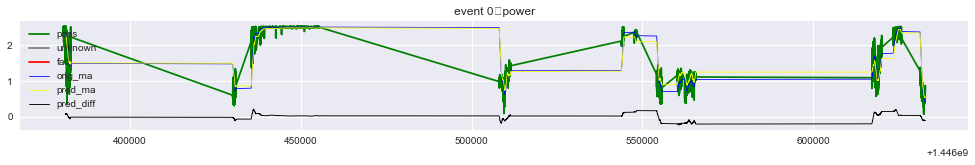

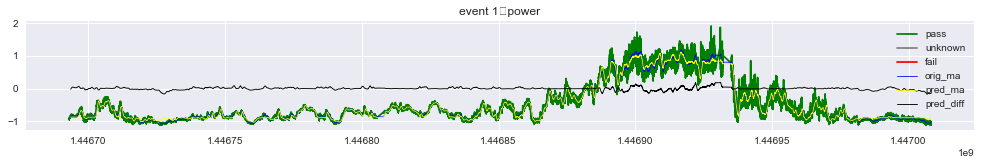

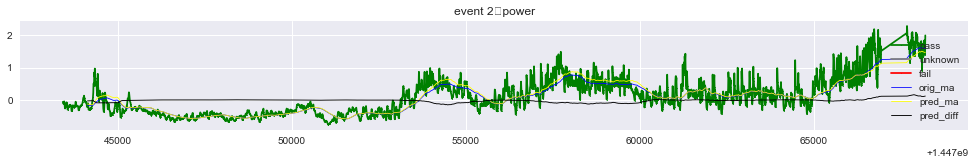

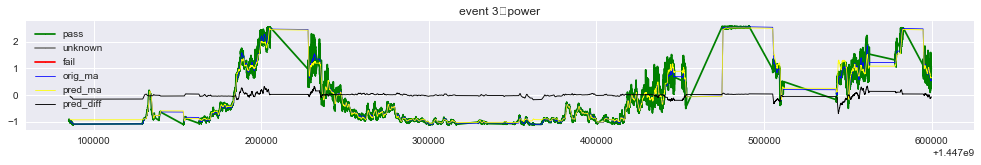

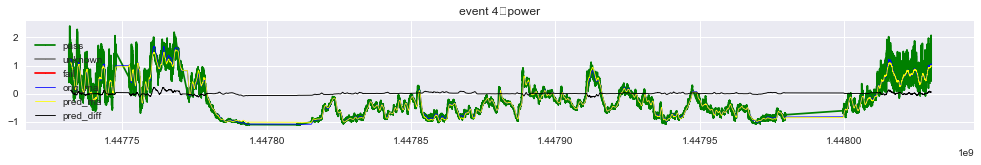

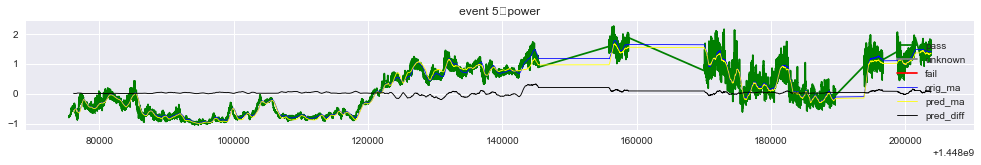

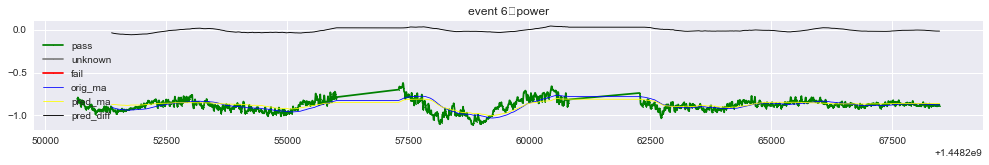

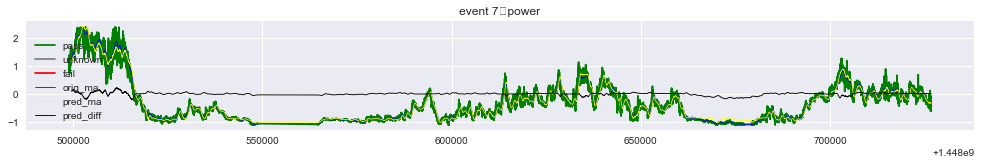

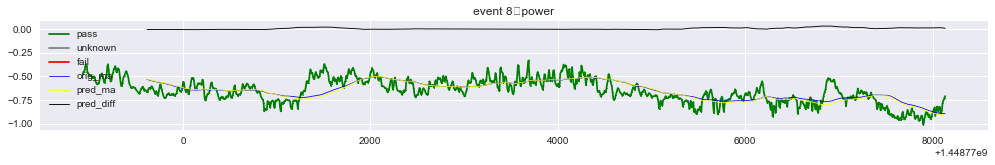

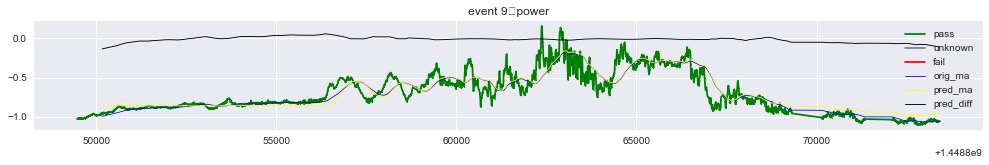

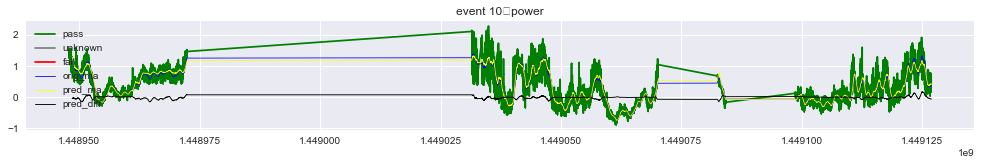

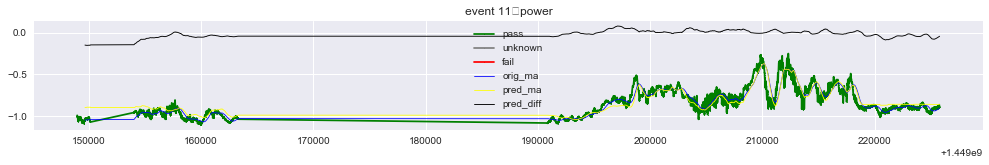

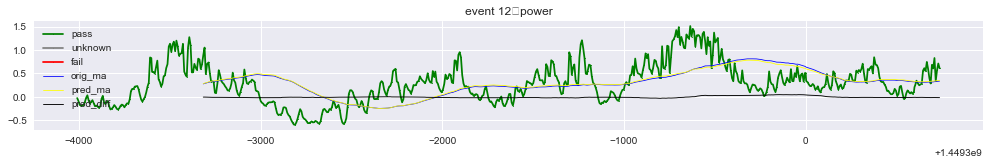

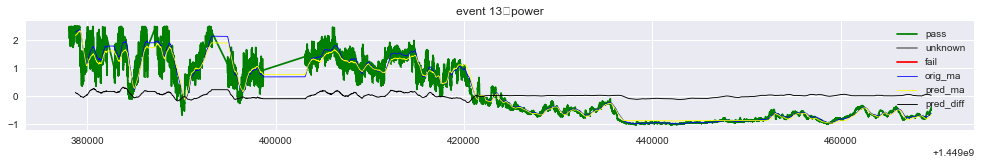

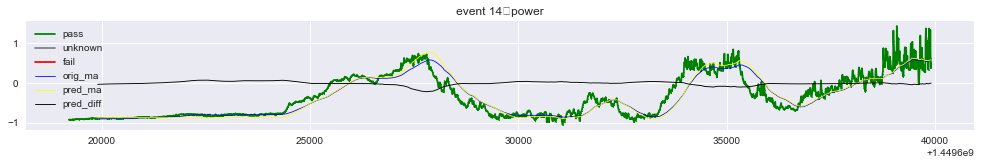

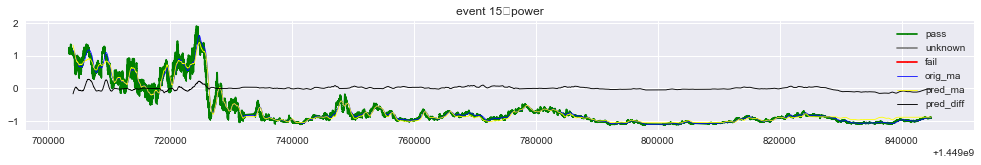

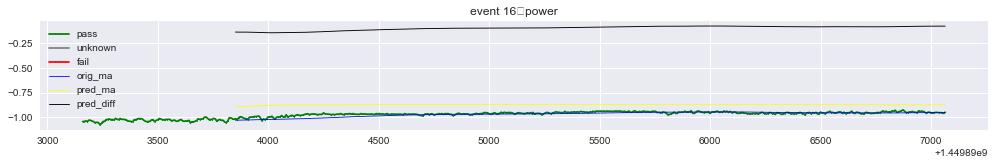

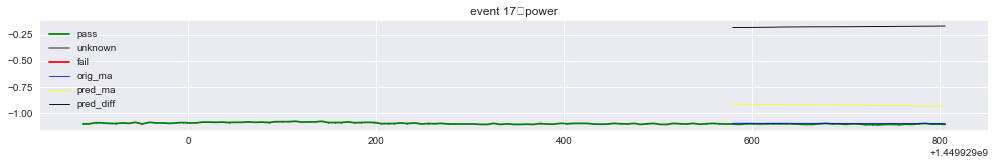

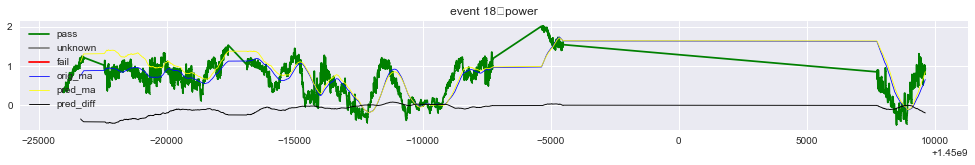

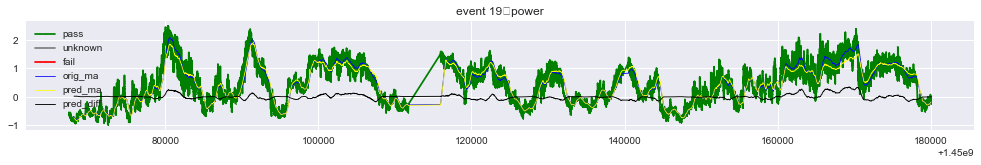

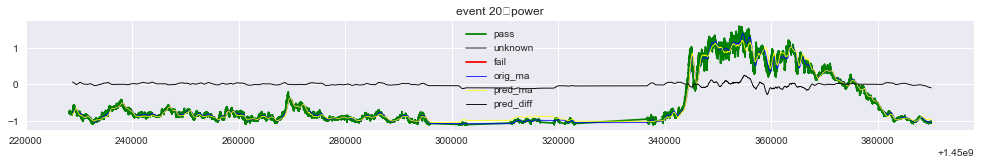

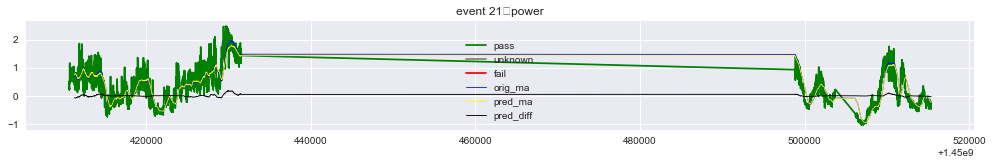

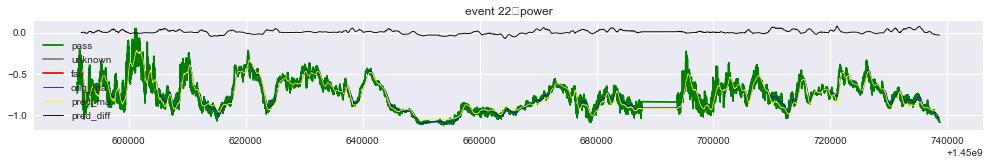

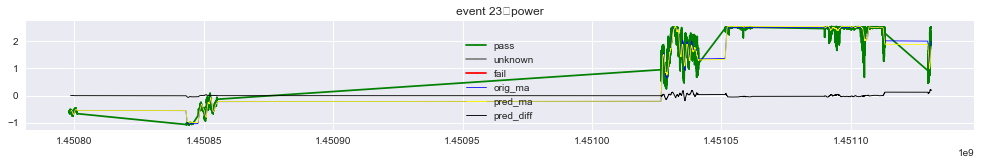

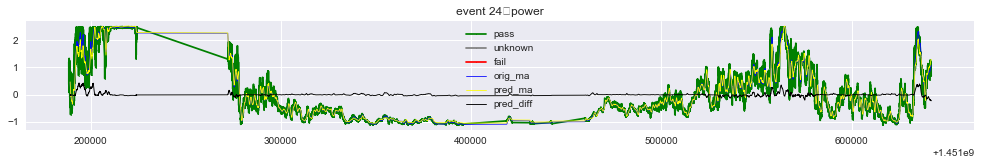

In [37]:
tmp_data = tmp_raw[['event','power','label','timestamp']]
tmp_data['pred'] = pred_y
trend_chart(tmp_data, events,varlist=['power'], ma=100)
    

***